## 1.0 Problem Statement
Hackathon One – Air Quality
(June 1 09:00 to June 5 23:59)
1. Is there a correlation between air quality and incidence and severity of COVID-19 infection?
2. What is the air quality threshold we need to meet to improve individual outcomes?

## 2.0 Solution Approach
In order to establish a relationship between air quality and COVID-19 infection rate, a thorough analysis needs to be done to understand the parameters of air quality and the infection rate at different geographical areas. There are over 1500 sites across the UK that monitor air quality. The overall air pollution index for a site or region is determined by the highest concentration of five pollutants:

Nitrogen Dioxide,
Sulphur Dioxide,
Ozone,
Particles < 2.5µm (PM2.5),
Particles < 10µm (PM10),

In addition to air pollutants level, the quality of air also depends on humidity, temperature, wind speed etc. In this study, all these factors have been taken into consideration for defining the air quality of a particular area. This data is available at [AQICN](https://aqicn.org/data-platform/covid19/) and aggregated at daily level for different UK cities. 

COVID-19 infection rate and the number of deaths is also available online at various web sites including WHO. However, this data is available at country level and hence not suitable to join with air quality data.There is a [github](https://github.com/tomwhite/covid-19-uk-data) site where COVID-19 data is available at UK local area authority level (lower grain than air quality data). This dataset has been used in this study and joined with the above air quality data. 

The study has been split into two iterations based on the joining methods of the above datasets.

1. Iteration 1 :- The air quality data and Covid-19 data have been joined based on city and reporting date attributes. 
2. Iteration 2 :- The impact of poor air quality (e.g. high humidity, high NO2 concentration) may be reflected in the total infection cases after several days. Therefore, in the second iteration, a lag of 7 days has been added to the COVID-19 data i.e. air quality metrics observed on 01/04/2020 has been joined with Covid-19 cases reported on 08/04/2020.


## 3.0 Data Sources

Air Quality Datasets

https://aqicn.org/data-platform/covid19/verify/89e538c6-ec60-415d-843b-e3a8476f2647
http://www.ukatmosphere.org/dataplot/DEFRA_sites

Regionwise COVID-19 Datasets

https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data
https://github.com/tomwhite/covid-19-uk-data
https://data.london.gov.uk/dataset/coronavirus--covid-19--cases

Population Data

https://www.ons.gov.uk/peoplepopulationandcommunity/populationandmigration/populationestimates/

## 4.0 Data Analysis
### 4.1 Data Preparation 
##### 4.1.1 Import Modules

In [282]:
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
sns.set(style="darkgrid")
from sklearn.metrics import r2_score, explained_variance_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split, KFold, cross_val_predict
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns
from datetime import datetime
import matplotlib.image as mpimg
%matplotlib inline

##### 4.1.2 Read Air Quality Data
The Air Quality data file has been downloaded from [AQICN](https://aqicn.org/data-platform/covid19/). This file contains the median and variance for the key air quality contributing elements such as NO2, SO2 etc. for different UK citites every day.     

In [283]:
df_aq_may=pd.read_csv("C:\\3-knowledge\\Hackathon\\UK\\Python\\airqua_data_till_may.csv", delimiter = ',')
print("No of rows and columns in the file",df_aq_may.shape)
print("Sample records from the file ")
df_aq_may.head(5)

No of rows and columns in the file (23128, 6)
Sample records from the file 


,Date,Country,City,Specie,median,variance
0,01/02/2020,GB,Edinburgh,pm10,6.0,213.90
1,01/02/2020,GB,Edinburgh,pressure,987.1,541.88
2,01/02/2020,GB,Edinburgh,so2,2.1,23.91
3,01/02/2020,GB,Edinburgh,no2,8.3,1002.50
4,01/02/2020,GB,Edinburgh,wind gust,19.0,1955.01


##### 4.1.2 Read Covid-19 Data
The Covid-19 data file has been downloaded from [github](https://github.com/tomwhite/covid-19-uk-data). This file contains 
the number of total cases everyday for different UK cities. This file has been amended with population for every 
city. The total number of cases and population of a city has been used to define a new COVID-19 metric 
(growth rate per 100K population). The population data has been downloaded from [ONS](https://www.ons.gov.uk/peoplepopulationandcommunity/populationandmigration/populationestimates).

In [284]:
df_cd_may=pd.read_csv("C:\\3-knowledge\\Hackathon\\UK\\Python\\covid_data_till_may.csv", delimiter = ',')
#Rename column 'Area' to 'City' to match with Air Quality file
df_cd_may.rename(columns={'Area':'City'}, inplace=True)
#Drop redundant columns
df_cd_may.drop(['Country', 'AreaCode'], axis=1,inplace=True)
print("No of rows and columns in the file ",df_cd_may.shape)
print("Sample records from the file ")
df_cd_may.tail(5)

No of rows and columns in the file  (1610, 4)
Sample records from the file 


,Date,City,TotalCases,Population
1605,30/05/2020,London,26989.0,8961989
1606,31/05/2020,Belfast,1303.0,340220
1607,31/05/2020,Glasgow,3946.0,633120
1608,31/05/2020,Edinburgh,2709.0,524930
1609,31/05/2020,London,26989.0,8961989


### 4.2 Explore Datasets
##### 4.2.1 Compare files for matching keys
Please note that Covid-19 data grain is not same as Air Quality data grain - while Covid-19 data is available at Local Authority and city level, air quality data is available only at the city level. Therefore, only a subset of Covid-19 data has been selected which can be matched with Air Quality data. 

Air Quality data is also avaialble in a highly normalised structure, this data needs to be pivoted on the column 'Specie' (i.e. define a column for SO2, NO2, PM25 etc.) before joining with Covid-19 data. 

In [285]:
df_aq_may_pv=df_aq_may.pivot_table('median',['Date','City'],'Specie') #,margins=True)
long_df_aq_may_pv=df_aq_may_pv.reset_index()

#print("Air quality data before pivot") 
#df_aq_may.head(4)
print("Air quality data after pivot")
long_df_aq_may_pv.head(4)

Air quality data after pivot


Specie,Date,City,co,dew,humidity,no2,o3,pm10,pm25,pressure,so2,temperature,wind gust,wind speed,wind-gust,wind-speed
0,01/02/2020,Belfast,1.0,4.5,79.8,11.9,17.9,15.0,34.0,993.0,1.8,8.3,14.7,7.7,NaN,NaN
1,01/02/2020,Birmingham,NaN,NaN,78.5,2.7,30.6,12.0,29.0,1000.8,NaN,9.0,10.8,5.8,NaN,NaN
2,01/02/2020,Bristol,2.2,NaN,82.4,6.1,28.9,28.0,53.0,1004.9,3.1,9.4,10.8,3.3,NaN,NaN
3,01/02/2020,Cardiff,2.2,NaN,85.3,4.2,28.5,25.0,38.0,1001.3,3.1,8.8,19.2,10.5,NaN,NaN


##### 4.2.2 Check basic statistics
Check the number of records available per city in each of the files. Also check the list of air quality factors which are sparsely populated i.e. NaN in most of the rows. These records need to be dropped/imputed at a later stage. 

In [286]:
print ('Basic statistics of pivotted Air Quality data')
long_df_aq_may_pv.describe()

Basic statistics of pivotted Air Quality data


Specie,co,dew,humidity,no2,o3,pm10,pm25,pressure,so2,temperature,wind gust,wind speed,wind-gust,wind-speed
count,879.000000,609.000000,2095.000000,2400.000000,2388.000000,2392.000000,2385.000000,2095.000000,1705.000000,2095.000000,857.000000,882.000000,1125.000000,1220.000000
mean,2.641866,4.251232,72.495370,6.667417,25.963023,14.469482,32.745493,1018.555179,2.371496,9.548162,10.215869,4.697166,6.878667,2.952787
std,2.707292,3.113020,13.405788,4.355166,6.088006,7.482135,18.193480,23.628296,1.777070,4.124466,5.639887,3.075531,4.017292,1.916339
min,0.200000,-4.000000,10.000000,0.700000,0.700000,2.000000,4.000000,968.500000,0.200000,0.200000,0.300000,0.100000,0.100000,0.100000
25%,1.100000,2.000000,64.200000,3.700000,23.400000,9.000000,21.000000,1009.000000,1.100000,6.600000,5.900000,2.500000,4.000000,1.600000
50%,2.200000,4.000000,72.500000,5.500000,26.900000,13.000000,27.000000,1018.500000,1.900000,9.000000,9.600000,4.100000,6.000000,2.600000
75%,3.400000,6.000000,82.000000,8.100000,29.700000,18.000000,41.000000,1024.300000,3.100000,12.400000,14.000000,6.400000,9.000000,3.800000
max,22.100000,12.500000,100.000000,31.500000,55.000000,54.000000,144.000000,1209.200000,25.900000,22.300000,43.700000,28.200000,27.000000,13.700000


In [252]:
print ('Basic statistics of pivotted Covid-19 data')
df_cd_may.describe()

Basic statistics of pivotted Covid-19 data


,TotalCases,Population
count,1604.000000,1.610000e+03
mean,1782.838529,1.090360e+06
std,4467.850166,2.277183e+06
min,0.000000,1.546760e+05
25%,111.000000,2.469930e+05
50%,622.500000,3.715210e+05
75%,1639.750000,5.848530e+05
max,26989.000000,8.961989e+06


In [287]:
print("Air Quality - no of records for each city \n ---------------\n",long_df_aq_may_pv.groupby("City")["Date"].count())
print("Covid-19 - no of records for each city \n ---------------",df_cd_may.groupby("City")["Date"].count())
print("\n Count blank (NaN) values in each column (sparsely populated factors) \n ---------------\n")
print(long_df_aq_may_pv.isnull().sum(axis = 0))

#output pivotted file for future use (iteration 2)
long_df_aq_may_pv.to_csv("C:\\3-knowledge\\Hackathon\\UK\\Python\\long_df_aq_may_pv.csv")

Air Quality - no of records for each city 
 ---------------
 City
Belfast            120
Birmingham         120
Bristol            120
Cardiff            120
Coventry           120
Edinburgh          120
Glasgow            120
Leeds              120
Leicester          120
Liverpool          120
London             120
Luton                3
Manchester         120
Newport            120
Norwich            120
Plymouth           120
Preston            120
Reading            120
Sheffield          120
Southend-on-Sea    120
Swansea            120
Name: Date, dtype: int64
Covid-19 - no of records for each city 
 --------------- City
Belfast             43
Birmingham          87
Bristol             77
Cardiff            109
Coventry            76
Edinburgh           86
Glasgow             86
Leeds               84
Leicester           79
Liverpool           83
London             123
Luton               68
Manchester          84
Newport            109
Plymouth            70
Reading            

### 4.3 Iteration 1  
##### 4.3.1 Join Air Quality data and Covid-19 data based on Date and City

The Air Quality data and Covid-19 data have been joined based on city and date in the first iteration. However, the impact of poor air quality (e.g. high humidity, high No2 concentration) may be reflected in the total number of cases after several days.

In the next iteration, a lag of 7 days has been factored in i.e. Air Quality metrics observed on 01/04/2020 has been joined with Covid-19 cases reported on 08/04/2020.

The variables with NaN values have been dropped from the combined dataset. Also, the combined output has been saved in a CSV file for metric definition. This file is ordered by City and Date.

In [288]:
# join the datasets and reset the index
df_aq_cd_may=pd.concat([df.set_index(['Date', 'City']) for df in [long_df_aq_may_pv,df_cd_may]], axis=1).reset_index()
print("Column names in the combined dataset",df_aq_cd_may.columns)
'''
No of blank values in the following factors
Date              0
City              0
humidity        308
no2               3
o3               15
pm10             11
pm25             18
pressure        308
temperature     308  --use the above metrics

so2             698  --impute with average values for next iternation

wind gust      1546  --ignore the following metrics ('wind gust' and 'wind-gust' need to be merged in the next iteration)
wind speed     1521
wind-gust      1278
wind-speed     1183
co             1524
dew            1794

For SO2, only the following cities data can be imputed
Coventry
Louton
Norwich
Plymouth
Reading
Shefield
Southend-on-sea
'''
df_aq_cd_may_data=df_aq_cd_may[["City","Date","no2","o3","pm10","pm25","humidity",\
                                "pressure","temperature","TotalCases","Population"]]
print("Size of the dataset after dropping Y variables with NaN")
print(df_aq_cd_may_data.dropna(subset=['TotalCases', 'Population']).shape)
print("Size of the dataset after dropping all variables with NaN")
df_aq_cd_may_data_nona = df_aq_cd_may_data.dropna()
#df_aq_cd_may_data_nona = df_aq_cd_may_data.dropna(subset=['TotalCases', 'Population'])
print(df_aq_cd_may_data_nona.shape)
#print(df_aq_cd_may_data_nona.groupby("City")["Date"].count())

# The combined dataset has been saved for adding more COVID-19 metrcics
df_aq_cd_may_data_nona.to_csv("C:\\3-knowledge\\Hackathon\\UK\\Python\\df_aq_cd_may_data.csv")
#df_aq_cd_may_data_nona.head(20)


Column names in the combined dataset Index(['Date', 'City', 'co', 'dew', 'humidity', 'no2', 'o3', 'pm10', 'pm25',
       'pressure', 'so2', 'temperature', 'wind gust', 'wind speed',
       'wind-gust', 'wind-speed', 'TotalCases', 'Population'],
      dtype='object')
Size of the dataset after dropping Y variables with NaN
(1604, 11)
Size of the dataset after dropping all variables with NaN
(1464, 11)


##### 4.3.2 Metrics calculation 
The following metrcis have been calculated in Microsoft Excel for each city on a particular date. The dataset (df_aq_cd_may_data.csv) saved in the previous step has been used to define these metrics. We will mainly focus on the 1st and 3rd metric. The metric defintion has been taken from [this document](https://www.staceybarr.com/measure-up/an-insight-from-the-covid-19-metric-growth-factor/).

1.daily_growth_rt_percent = ( today's count / yesterday's count )*100

2.daily_growth_abs_num = today's count - yesterday's count 

3.daily_growth_rt_by_popu_percent =  ((today's count / yesterday's count)/Population)*100,000  (Note:-per 100K population)

In [256]:
#Read the file 
df_aq_cd_with_metric=pd.read_csv("C:\\3-knowledge\\Hackathon\\UK\\Python\\df_aq_cd_may_data_sorted_with_metric.csv", \
                                 delimiter = ',')
#print("Row and columns of the file ",df_aq_cd_with_metric.shape)

#Covert Date varible from string to date
df_aq_cd_with_metric['Date']=pd.to_datetime(df_aq_cd_with_metric.Date,format='%d/%m/%Y')
print("Size=",df_aq_cd_with_metric.shape,"Min Date=",df_aq_cd_with_metric['Date'].min(),"Max Date=",\
      df_aq_cd_with_metric['Date'].max())
df_aq_cd_with_metric.sort_values(by='Date')
df_aq_cd_with_metric.head(4)

Size= (1464, 16) Min Date= 2020-02-01 00:00:00 Max Date= 2020-05-30 00:00:00


,No,No1,City,Date,no2,o3,pm10,pm25,humidity,pressure,temperature,TotalCases,Population,daily_growth_rt_percent,daily_growth_abs_num,daily_growth_rt_by_popu_percent
0,1,2080,Belfast,2020-03-26,11.9,17.1,17,30,81.0,1026.0,7.5,75,340220,0.00,0.0,0.00
1,2,2162,Belfast,2020-03-27,8.3,15.5,14,21,87.0,1029.0,8.0,86,340220,114.67,11.0,33.70
2,3,2452,Belfast,2020-03-31,4.7,32.5,17,23,72.5,1036.5,7.0,166,340220,193.02,80.0,56.73
3,4,40,Belfast,2020-04-01,4.9,29.7,11,21,78.5,1024.5,8.0,200,340220,120.48,34.0,35.41


##### 4.3.3 Exploratory Data Analysis (EDA)

Independent variables (X) - all variables taken from Air Quality dataset e.g.no2,o3,pm10,pm25 etc.

Depenendent Variable (y) - Covid-19 'TestCases' and all derived metrics. However, only 'daily_growth_rt_by_popu_percent' and 'daily_growth_rt_percent' have been used in the following analysis.

Explore the of daily changes in both X and y variables for a few cities across the region. Growth rate for Codvid-19 postive cases have been further standardised based on the city's population so that the data from different cities can be compared in the same plot. 

###### 4.3.3.1 - Daily variation of X and y variables for different cities
From the diagram below, Plymouth (green line) has clearly higher values of 'daily_growth_rt_by_popu_percent' compared to other cities and higher levels of pm10, pm25, o3, humidity and temperature.

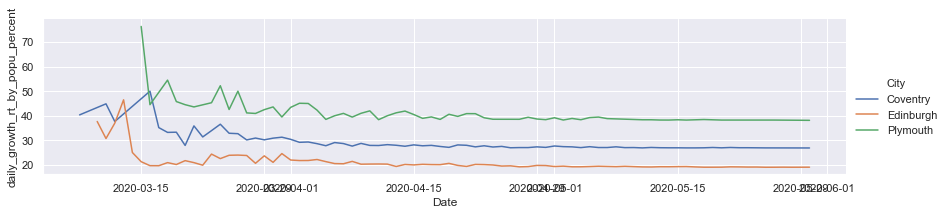

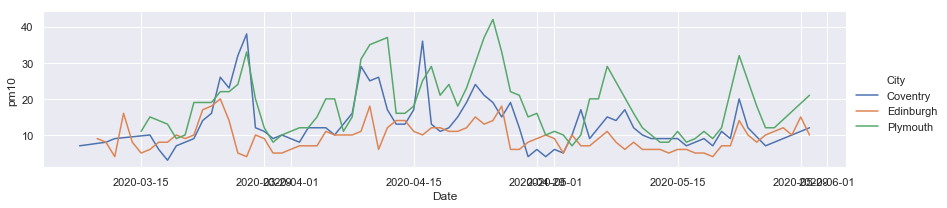

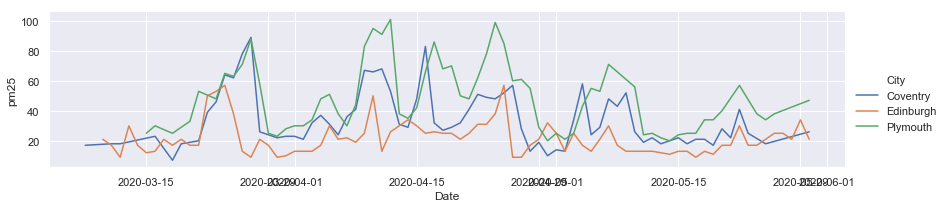

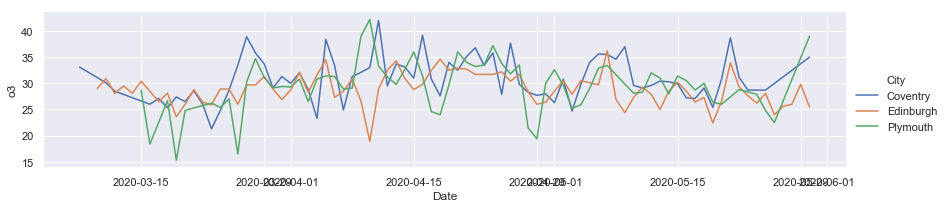

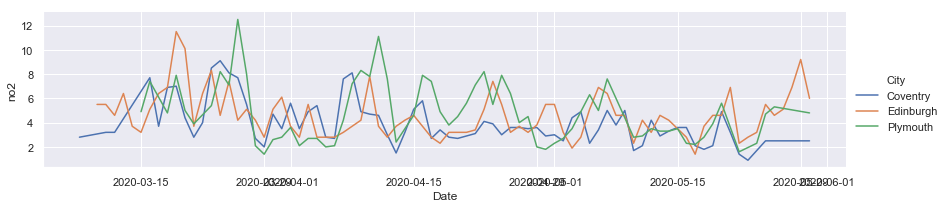

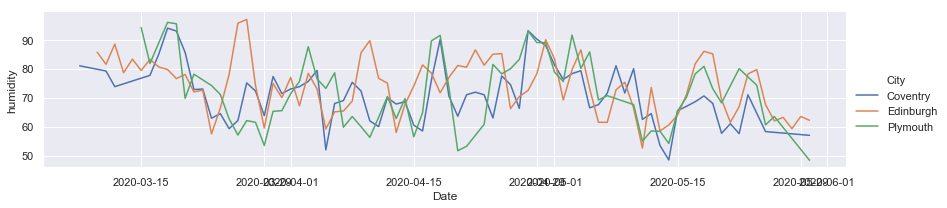

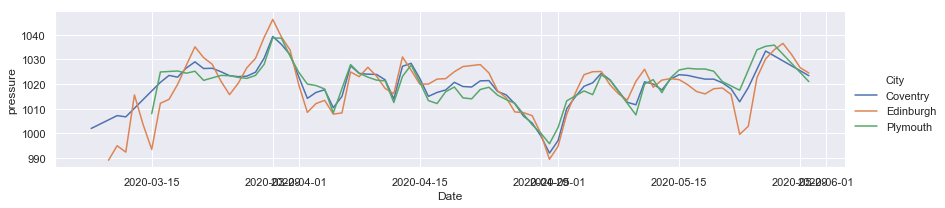

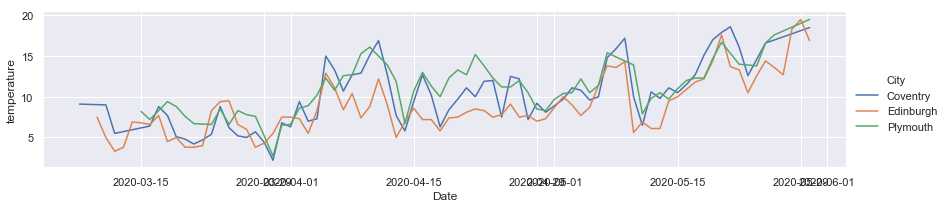

In [289]:
## Plot the data for a few cities - Edinburgh is less polluted compared to Plymouth
cities=['Plymouth','Edinburgh','Coventry']
df_aq_cd_with_metric_plot_3=df_aq_cd_with_metric[df_aq_cd_with_metric.City.isin(cities)]
sns.relplot(x="Date", y="daily_growth_rt_by_popu_percent", hue="City", height=3,aspect=4,data=df_aq_cd_with_metric_plot_3,kind="line");
sns.relplot(x="Date", y="pm10", hue="City", height=3,aspect=4,data=df_aq_cd_with_metric_plot_3,kind="line");
sns.relplot(x="Date", y="pm25", hue="City", height=3,aspect=4,data=df_aq_cd_with_metric_plot_3,kind="line"); 
sns.relplot(x="Date", y="o3", hue="City", height=3,aspect=4,data=df_aq_cd_with_metric_plot_3,kind="line"); 
sns.relplot(x="Date", y="no2", hue="City", height=3,aspect=4,data=df_aq_cd_with_metric_plot_3,kind="line");
sns.relplot(x="Date", y="humidity", hue="City", height=3,aspect=4,data=df_aq_cd_with_metric_plot_3,kind="line");
sns.relplot(x="Date", y="pressure", hue="City", height=3,aspect=4,data=df_aq_cd_with_metric_plot_3,kind="line");
sns.relplot(x="Date", y="temperature", hue="City", height=3,aspect=4,data=df_aq_cd_with_metric_plot_3,kind="line");


###### 4.3.3.2 - Corelation of X and y variables for different cities
Let us investigate the correlation between NO2 (x) and daily_growth_rt_by_popu_percent (y). 

========================== NO2 vs daily_growth_rt_by_popu_percent for each city ===============



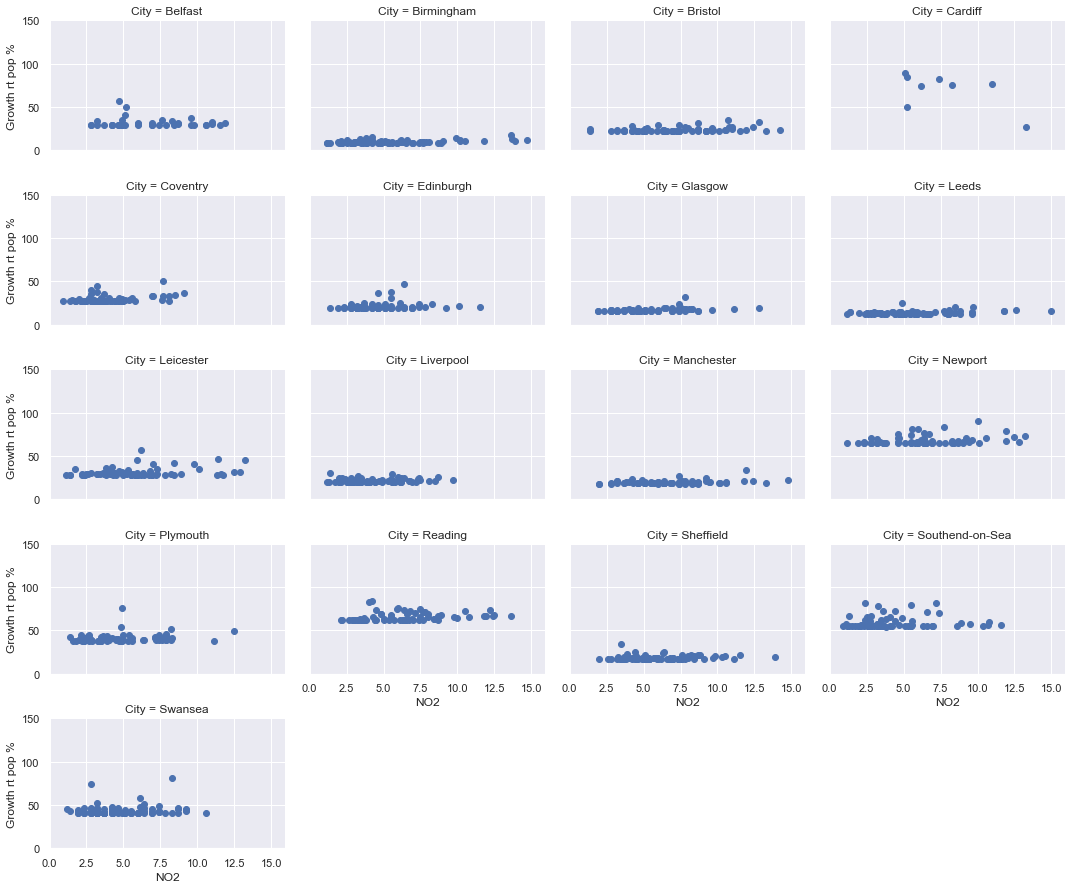

In [290]:
print("========================== NO2 vs daily_growth_rt_by_popu_percent for each city ===============\n")
#df_aq_cd_with_metric = df_aq_cd_with_metric[(df_aq_cd_with_metric.no2<=20)]
g=sns.FacetGrid(df_aq_cd_with_metric, col="City", aspect=1.5,col_wrap=4, height=2.5 , ylim=(0, 150))
g=g.map(plt.scatter,"no2", "daily_growth_rt_by_popu_percent", alpha=1.0)
g=g.add_legend()
# rename daily_growth_rt_by_popu_percent to "Growth rt pop %"
g=g.set_axis_labels("NO2","Growth rt pop %")

In the above diagrams, Cardiff's and London's data are different from other cities. Removing the outliers i.e. the rows with y>=100 and x>=15, the data been plotted for all the cities. Please refer to the figures below. 

From both the figures below, it is clear that there is a weak correlation exists between NO2 and daily_growth_rt_by_popu_percent.

1. Relationship between NO2 and daily_growth_rt_by_popu_percent for 3 cities 

2. Relationship between NO2 and daily_growth_rt_by_popu_percent for all cities after removing outliers 

Figure 1- Relationship between No2 and daily_growth_rt_by_popu_percent for 3 cities


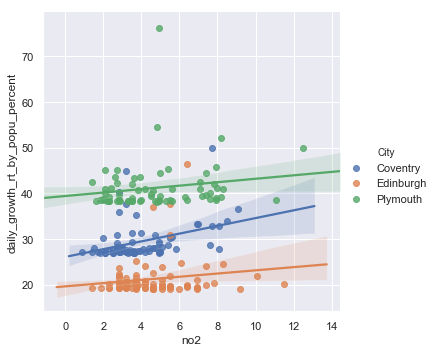

In [291]:
print("Figure 1- Relationship between No2 and daily_growth_rt_by_popu_percent for 3 cities")
sns.lmplot(x="no2", y="daily_growth_rt_by_popu_percent", hue="City", data=df_aq_cd_with_metric_plot_3)

Figure 2- Relationship between No2 and daily_growth_rt_by_popu_percent for all cities after removing outliers


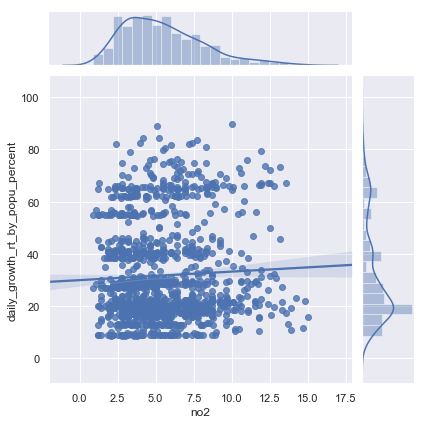

In [292]:
print("Figure 2- Relationship between No2 and daily_growth_rt_by_popu_percent for all cities after removing outliers")
df_aq_cd_with_metric = df_aq_cd_with_metric[(df_aq_cd_with_metric.no2<=15)]
df_aq_cd_with_metric = df_aq_cd_with_metric[(df_aq_cd_with_metric.daily_growth_rt_by_popu_percent<=90)]
df_aq_cd_with_metric = df_aq_cd_with_metric[(df_aq_cd_with_metric.daily_growth_rt_by_popu_percent>=5)]
sns.jointplot(x="no2", y="daily_growth_rt_by_popu_percent", data=df_aq_cd_with_metric,kind="reg");

###### 4.3.3.4 - Exclude outliers and plot the correlation for all X variables
The same joint plots have been created for all X variables below for a different metric 'daily_growth_rt_percent'

size of the dataste after excluding outliers (1144, 16)
Size of df_aq_cd_with_metric_plot (1144, 16)
Size of df_aq_cd_with_metric_plot (1144, 16)


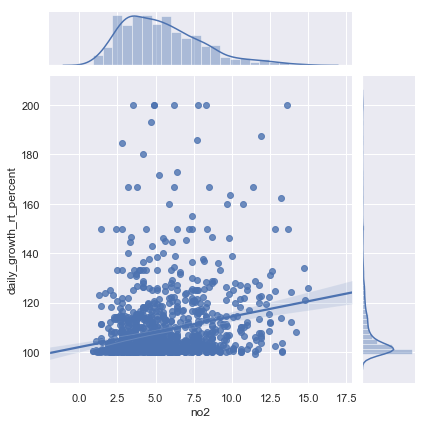

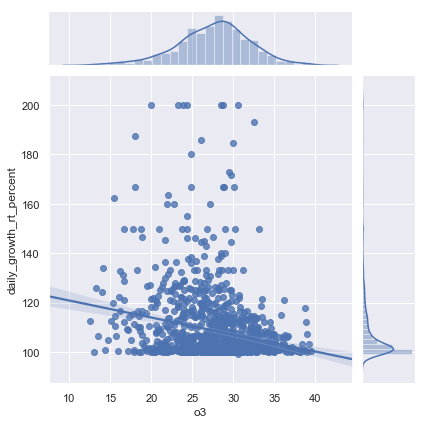

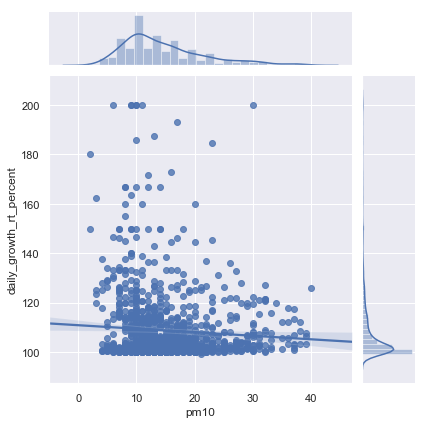

In [263]:
#city_list=['Belfast','Birmingham','Bristol','Cardiff','Coventry',\
# 'Edinburgh','Glasgow','Leeds','Leicester','Liverpool','London','Luton','Manchester','Newport','Norwich','Plymouth','Preston','Reading','Sheffield','Southend-on-Sea','Swansea']

# Drop London and Louton for missing and boundary conditions of data
city_list=['Belfast','Birmingham','Bristol','Cardiff','Coventry','Edinburgh', \
           'Glasgow','Leeds','Leicester','Liverpool','Manchester','Newport','Norwich','Plymouth',\
           'Preston','Reading','Sheffield','Southend-on-Sea','Swansea']


df_aq_cd_with_metric_plot=df_aq_cd_with_metric[df_aq_cd_with_metric.City.isin(city_list)]
#print(df_aq_cd_with_metric_plot.columns)
#Exclude outliers to focus on the mass of data
df_aq_cd_with_metric_plot = df_aq_cd_with_metric_plot[(df_aq_cd_with_metric_plot.daily_growth_rt_by_popu_percent<=100)]
#df_aq_cd_with_metric_plot = df_aq_cd_with_metric_plot[(df_aq_cd_with_metric_plot.daily_growth_rt_percent>=100)]

df_aq_cd_with_metric_plot = df_aq_cd_with_metric_plot[(df_aq_cd_with_metric_plot.no2<=15)]
df_aq_cd_with_metric_plot = df_aq_cd_with_metric_plot[(df_aq_cd_with_metric_plot.o3<=40)]
df_aq_cd_with_metric_plot = df_aq_cd_with_metric_plot[(df_aq_cd_with_metric_plot.pm10<=40)]
df_aq_cd_with_metric_plot = df_aq_cd_with_metric_plot[(df_aq_cd_with_metric_plot.pm25<=90)]
df_aq_cd_with_metric_plot = df_aq_cd_with_metric_plot[(df_aq_cd_with_metric_plot.humidity>=40)]
df_aq_cd_with_metric_plot = df_aq_cd_with_metric_plot[(df_aq_cd_with_metric_plot.pressure<=1040)]

print('size of the dataste after excluding outliers',df_aq_cd_with_metric_plot.shape)
print('Size of df_aq_cd_with_metric_plot',df_aq_cd_with_metric_plot.shape)
#metric_name="daily_growth_rt_percent"
metric_name="daily_growth_rt_percent"
# few counts across cities and hence metric with population
h=4
g1=sns.jointplot(x="no2", y=metric_name, data=df_aq_cd_with_metric_plot,kind="reg");
g2=sns.jointplot(x="o3", y=metric_name, data=df_aq_cd_with_metric_plot,kind="reg");
g3=sns.jointplot(x="pm10", y=metric_name, data=df_aq_cd_with_metric_plot,kind="reg");
#g4=sns.jointplot(x="pm25", y=metric_name, data=df_aq_cd_with_metric_plot,kind="reg");
#g5=sns.jointplot(x="humidity", y=metric_name, data=df_aq_cd_with_metric_plot,kind="reg");
#g6=sns.jointplot(x="temperature", y=metric_name, data=df_aq_cd_with_metric_plot,kind="reg");
#g7=sns.jointplot(x="pressure", y=metric_name, data=df_aq_cd_with_metric_plot,kind="reg");

print('Size of df_aq_cd_with_metric_plot',df_aq_cd_with_metric_plot.shape)

Size of df_aq_cd_with_metric_plot (1144, 16)


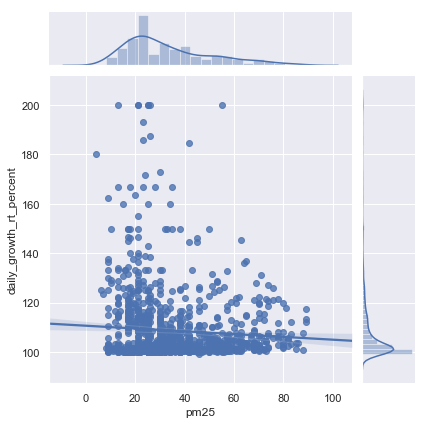

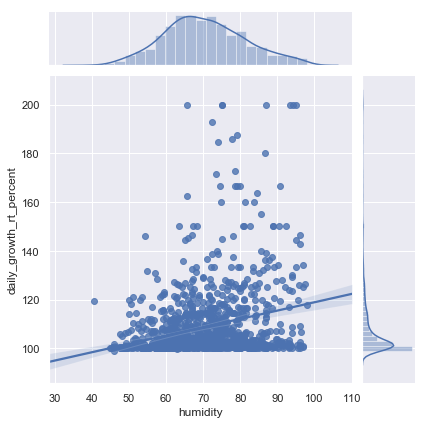

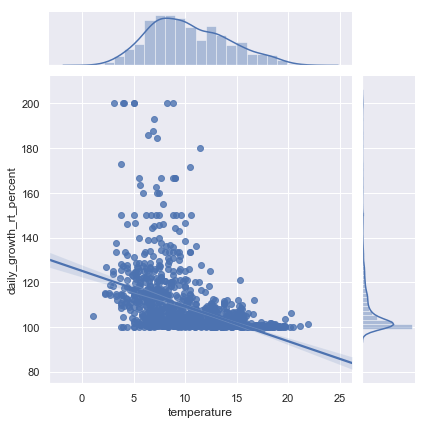

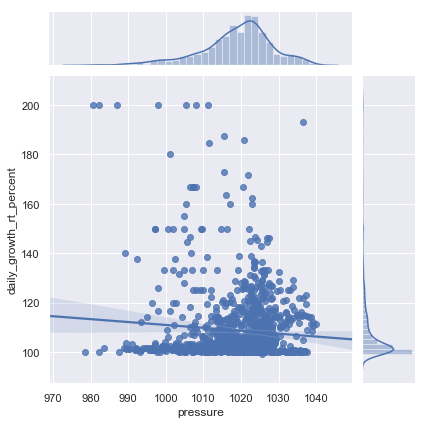

In [278]:
g4=sns.jointplot(x="pm25", y=metric_name, data=df_aq_cd_with_metric_plot,kind="reg");
g5=sns.jointplot(x="humidity", y=metric_name, data=df_aq_cd_with_metric_plot,kind="reg");
g6=sns.jointplot(x="temperature", y=metric_name, data=df_aq_cd_with_metric_plot,kind="reg");
g7=sns.jointplot(x="pressure", y=metric_name, data=df_aq_cd_with_metric_plot,kind="reg");
print('Size of df_aq_cd_with_metric_plot',df_aq_cd_with_metric_plot.shape)

##### 4.3.4  - Correlation Coeffient (r) and Model fitting for different metrics

1. Find the correlation coefficient between daily_growth_rt_percent and individual x parameters

2. Fit LinearRegression()

3. Fit RandomForestRegressor (max_depth=2, random_state=0)

In [279]:
#metric_list=["daily_growth_rt_by_popu_percent","daily_growth_rt_percent","TotalCases","daily_growth_abs_num"]
metric_list=["daily_growth_rt_percent"]
input_param_list=['no2','o3','pm10','pm25','humidity','temperature','pressure']
print('Size of df_aq_cd_with_metric_plot',df_aq_cd_with_metric_plot.shape)
for metric_name in metric_list:
    print("\nCorrelation between X and ",metric_name)
    for i in input_param_list:
        x = (df_aq_cd_with_metric_plot[i])
        y = (df_aq_cd_with_metric_plot[metric_name])
        print (i,' - Correlation coefficient is {:0.2f}'.format(np.corrcoef(x,y)[1,0]))
print("\n")

Size of df_aq_cd_with_metric_plot (1144, 16)

Correlation between X and  daily_growth_rt_percent
no2  - Correlation coefficient is 0.22
o3  - Correlation coefficient is -0.21
pm10  - Correlation coefficient is -0.07
pm25  - Correlation coefficient is -0.07
humidity  - Correlation coefficient is 0.25
temperature  - Correlation coefficient is -0.41
pressure  - Correlation coefficient is -0.08




In [281]:
metric_name="daily_growth_rt_percent"
X_all = (df_aq_cd_with_metric_plot[input_param_list])
y_all = (df_aq_cd_with_metric_plot[metric_name])

kf = KFold(n_splits=5, shuffle=True, random_state=0)
lm_mv_cv = LinearRegression()
predicted_mv_cv = cross_val_predict(lm_mv_cv, X_all, y_all, cv=kf)
print(lm_mv_cv.fit(X_all, y_all))

print (X_all.shape,y_all.shape)
print ('\nMulti-variate linear model\n')
print('Coefficient of Determination (R^2): %.2f' %lm_mv_cv.score(X_all,y_all))
print("Mean squared error(RMSE): %.2f"  %mean_squared_error(y_all, predicted_mv_cv))
print("Mean absolute error(MAE): %.2f"  %mean_absolute_error(y_all, predicted_mv_cv))

print ('\nMulti-variate Random Forest LinearRegressor\n')
rf_mv_cv_log_edit = RandomForestRegressor(max_depth=2, random_state=0)
predicted_mv_cv_log_edit_rf = cross_val_predict(rf_mv_cv_log_edit, X_all, y_all, cv=kf)
rf_mv_cv_log_edit.fit(X_all, y_all)

#print('Correlation Coeffcient',np.corrcoef(X_all,y_all))
print('Coefficient of Determination (R^2): %.2f' %rf_mv_cv_log_edit.score(X_all, y_all))
print("Mean squared error: %.2f"  %mean_squared_error(y_all, predicted_mv_cv_log_edit_rf))
print("Mean absolute error: %.2f"  %mean_absolute_error(y_all, predicted_mv_cv_log_edit_rf))

#As the metric daily_growth_rt_percent shows a higher r value, let us examine the graph for this metric 
#g1=sns.jointplot(x="no2", y="daily_growth_rt_percent", data=df_aq_cd_with_metric_plot,kind="reg");
#g2=sns.jointplot(x="o3", y="daily_growth_rt_percent", data=df_aq_cd_with_metric_plot,kind="reg");
#g5=sns.jointplot(x="humidity", y="daily_growth_rt_percent", data=df_aq_cd_with_metric_plot,kind="reg");


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)
(1144, 7) (1144,)

Multi-variate linear model

Coefficient of Determination (R^2): 0.22
Mean squared error(RMSE): 168.55
Mean absolute error(MAE): 7.94

Multi-variate Random Forest LinearRegressor

Coefficient of Determination (R^2): 0.25
Mean squared error: 174.01
Mean absolute error: 7.60


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: F

##### 4.3.5  - Conclusion of Iteration 1 

The above diagrams and the correlation coefficients show a clear relationshiop (not very strong though) between NO2, O3, humidity and temperature with the metric daily_growth_rt_percent ( (TotalCases today/TotalCases yesterday) * 100 ). This result needs to be validated with more data from different countries.  

Let us investigate further on this same metric 'daily_growth_rt_percent' in iteration 2 with a differnt type of join criteria. Also, SO2 and wind_speed data have also been added in iteration 2.  

### 4.4 Iteration 2  
##### 4.4.1 Join Air Quality data and Covid-19 data based on City and Date with 7 days lag.

The Air Quality data and Covid-19 data have been joined based on city and date in the first iteration. However, the impact of poor air quality (e.g. high NO2 concentration) may be reflected in the count of total cases after several days.

In this iteration, a lag of 7 days has been factored in i.e. Air Quality metrics observed on 01/04/2020 has been joined with Covid-19 cases reported on 08/04/2020. This dataset has been created from the previous datasets in Microsoft Excel. 

Also dropped variables with NaN values in the combined dataset. 

Note:- This dataset has additional X variables SO2, merged_wind_gust and merged_wind_speed (wind_??? columns were split into two columns in the previous dataset which were mered into one column in this dataset) This dataset has been created in Microsoft Excel using the raw source data files mentioned above.
  

In [269]:
#Reading a new with Day +7 match
df_aq_day1_joined_cd_day7_with_metrics=pd.read_csv("C:\\3-knowledge\\Hackathon\\UK\\Python\\aq_day1_joined_cd_day7_with_metrics.csv", delimiter = ',')
print('Shape of the dataset =', df_aq_day1_joined_cd_day7_with_metrics.shape)
df_aq_day1_joined_cd_day7_with_metrics.head(10)

Shape of the dataset = (1552, 19)


,Date,City,co,dew,humidity,no2,o3,pm10,pm25,pressure,so2,temperature,merged_wind_gust,merged_wind_speed,Dplus7,Dplus7City,TotalCases,Population,daily_growth_rt_percent
0,19/03/2020,Belfast,2.5,1.0,80.0,12.4,19.1,20.0,30.0,1030.0,1.6,3.0,NaN,2.5,26/03/2020,43916Belfast,75.0,340220.0,0.000000
1,20/03/2020,Belfast,2.6,0.0,75.0,11.9,19.9,18.0,25.0,1033.0,1.6,5.0,NaN,4.8,27/03/2020,43917Belfast,86.0,340220.0,114.666667
2,23/03/2020,Belfast,3.3,4.5,81.0,9.2,19.5,29.0,NaN,1021.0,1.7,8.0,NaN,4.3,30/03/2020,43920Belfast,160.0,340220.0,186.046512
3,24/03/2020,Belfast,3.0,5.5,72.5,5.5,27.4,32.0,NaN,1016.0,1.6,10.0,12.8,5.1,31/03/2020,43921Belfast,166.0,340220.0,103.750000
4,25/03/2020,Belfast,3.1,7.5,87.0,12.0,24.2,25.0,50.0,1021.0,1.8,10.0,NaN,4.3,01/04/2020,43922Belfast,200.0,340220.0,120.481928
5,26/03/2020,Belfast,NaN,5.5,81.0,11.9,17.1,17.0,30.0,1026.0,0.9,7.5,NaN,4.1,02/04/2020,43923Belfast,226.0,340220.0,113.000000
6,27/03/2020,Belfast,0.7,6.0,87.0,8.3,15.5,14.0,21.0,1029.0,1.1,8.0,NaN,4.8,03/04/2020,43924Belfast,272.0,340220.0,120.353982
7,30/03/2020,Belfast,NaN,3.0,75.0,5.5,NaN,16.0,35.0,1040.0,0.9,7.5,NaN,4.8,06/04/2020,43927Belfast,377.0,340220.0,138.602941
8,31/03/2020,Belfast,NaN,2.5,72.5,4.7,32.5,17.0,23.0,1036.5,0.7,7.0,NaN,3.3,07/04/2020,43928Belfast,396.0,340220.0,105.039788
9,01/04/2020,Belfast,0.9,3.5,78.5,4.9,29.7,11.0,21.0,1024.5,0.6,8.0,NaN,4.1,08/04/2020,43929Belfast,429.0,340220.0,108.333333


In [217]:
# Check basic statistics
df_aq_day1_joined_cd_day7_with_metrics.describe()

,co,dew,humidity,no2,o3,pm10,pm25,pressure,so2,temperature,merged_wind_gust,merged_wind_speed,TotalCases,Population,daily_growth_rt_percent
count,667.000000,432.000000,1453.000000,1527.000000,1522.000000,1522.00000,1516.000000,1453.000000,1189.000000,1453.000000,1344.000000,1437.000000,1527.000000,1.527000e+03,1527.000000
mean,2.806597,4.315972,71.697798,6.444270,26.678252,15.25887,34.485488,1019.168754,2.325315,9.496972,8.206473,3.609743,1853.635232,1.084972e+06,104.485972
std,2.896553,3.214533,12.720999,3.939988,5.518260,7.97440,19.534562,23.153779,1.795404,3.647640,4.846850,2.409349,4567.323726,2.250972e+06,34.426808
min,0.200000,-4.000000,10.000000,0.900000,1.300000,2.00000,4.000000,973.100000,0.200000,1.100000,0.100000,0.200000,0.000000,1.546760e+05,0.000000
25%,1.100000,2.000000,64.300000,3.700000,24.000000,10.00000,21.000000,1011.300000,1.100000,6.900000,4.500000,2.000000,116.500000,2.621000e+05,100.552486
50%,2.400000,4.500000,71.500000,5.500000,27.400000,13.00000,30.000000,1018.600000,1.900000,9.100000,7.100000,3.000000,647.000000,4.633770e+05,102.348066
75%,3.600000,6.500000,80.600000,7.900000,30.100000,19.00000,46.000000,1023.800000,3.100000,12.200000,10.900000,4.700000,1712.000000,5.848530e+05,111.236616
max,22.100000,12.500000,98.000000,31.500000,55.000000,54.00000,144.000000,1197.600000,25.900000,22.300000,28.600000,15.000000,26989.000000,8.961989e+06,600.000000


##### 4.4.2 Exploratory Data Analysis
1. Remove blank values, sparsely populated columns and drop outliers
2. Find out the correlation coefficients 

In [270]:
#drop sparsely populated columns
df_aq_day1_joined_cd_day7_with_metrics_nona=df_aq_day1_joined_cd_day7_with_metrics.drop(['co','dew'],\
                                                                                        axis=1,inplace=False)
#drop blank values
df_aq_day1_joined_cd_day7_with_metrics_nona=df_aq_day1_joined_cd_day7_with_metrics_nona.dropna()

#drop outliers
df_aq_day1_joined_cd_day7_with_metrics_nona = df_aq_day1_joined_cd_day7_with_metrics_nona[(df_aq_day1_joined_cd_day7_with_metrics_nona.daily_growth_rt_percent>=100)]
df_aq_day1_joined_cd_day7_with_metrics_nona = df_aq_day1_joined_cd_day7_with_metrics_nona[(df_aq_day1_joined_cd_day7_with_metrics_nona.daily_growth_rt_percent<=150)]

df_aq_day1_joined_cd_day7_with_metrics_nona = df_aq_day1_joined_cd_day7_with_metrics_nona[(df_aq_day1_joined_cd_day7_with_metrics_nona.so2<=7.5)]
df_aq_day1_joined_cd_day7_with_metrics_nona = df_aq_day1_joined_cd_day7_with_metrics_nona[(df_aq_day1_joined_cd_day7_with_metrics_nona.no2<=15)]
df_aq_day1_joined_cd_day7_with_metrics_nona = df_aq_day1_joined_cd_day7_with_metrics_nona[(df_aq_day1_joined_cd_day7_with_metrics_nona.o3<=40)]
df_aq_day1_joined_cd_day7_with_metrics_nona = df_aq_day1_joined_cd_day7_with_metrics_nona[(df_aq_day1_joined_cd_day7_with_metrics_nona.pm10<=40)]
df_aq_day1_joined_cd_day7_with_metrics_nona = df_aq_day1_joined_cd_day7_with_metrics_nona[(df_aq_day1_joined_cd_day7_with_metrics_nona.pm25<=90)]
df_aq_day1_joined_cd_day7_with_metrics_nona = df_aq_day1_joined_cd_day7_with_metrics_nona[(df_aq_day1_joined_cd_day7_with_metrics_nona.humidity>=40)]
df_aq_day1_joined_cd_day7_with_metrics_nona = df_aq_day1_joined_cd_day7_with_metrics_nona[(df_aq_day1_joined_cd_day7_with_metrics_nona.pressure<=1040)]


input_param_list=['so2','no2','o3','pm10','pm25','humidity','temperature','pressure',\
                  'merged_wind_gust','merged_wind_speed']

metric_name='daily_growth_rt_percent'

print('Shape of the dataset after removing blank values and outliers =', \
      df_aq_day1_joined_cd_day7_with_metrics_nona.shape)
print ("\nCorrelation coefficient for metric",metric_name)
for i in input_param_list:
    x = (df_aq_day1_joined_cd_day7_with_metrics_nona[i])
    y = (df_aq_day1_joined_cd_day7_with_metrics_nona[metric_name])
    print (i,' - Correlation coefficient is {:0.2f}'.format(np.corrcoef(x,y)[1,0]))

Shape of the dataset after removing blank values and outliers = (878, 17)

Correlation coefficient for metric daily_growth_rt_percent
so2  - Correlation coefficient is -0.03
no2  - Correlation coefficient is 0.20
o3  - Correlation coefficient is -0.27
pm10  - Correlation coefficient is -0.17
pm25  - Correlation coefficient is -0.17
humidity  - Correlation coefficient is 0.36
temperature  - Correlation coefficient is -0.44
pressure  - Correlation coefficient is -0.16
merged_wind_gust  - Correlation coefficient is 0.28
merged_wind_speed  - Correlation coefficient is 0.32


In [272]:

X_all = (df_aq_day1_joined_cd_day7_with_metrics_nona[input_param_list])
y_all = (df_aq_day1_joined_cd_day7_with_metrics_nona[metric_name])

kf = KFold(n_splits=5, shuffle=True, random_state=0)
lm_mv_cv = LinearRegression()
predicted_mv_cv = cross_val_predict(lm_mv_cv, X_all, y_all, cv=kf)
lm_mv_cv.fit(X_all, y_all)

print (X_all.shape,y_all.shape)
print ('\nMulti-variate linear model\n')
print('Coefficient of Determination (R^2): %.2f' %lm_mv_cv.score(X_all,y_all))
print("Mean squared error(RMSE): %.2f"  %mean_squared_error(y_all, predicted_mv_cv))
print("Mean absolute error(MAE): %.2f"  %mean_absolute_error(y_all, predicted_mv_cv))

print ('\nMulti-variate Random Forest LinearRegressor\n')
rf_mv_cv_log_edit = RandomForestRegressor(max_depth=2, random_state=0)
predicted_mv_cv_log_edit_rf = cross_val_predict(rf_mv_cv_log_edit, X_all, y_all, cv=kf)
rf_mv_cv_log_edit.fit(X_all, y_all)

#print('Correlation Coeffcient',np.corrcoef(X_all,y_all))
print('Coefficient of Determination (R^2): %.2f' %rf_mv_cv_log_edit.score(X_all, y_all))
print("Mean squared error: %.2f"  %mean_squared_error(y_all, predicted_mv_cv_log_edit_rf))
print("Mean absolute error: %.2f"  %mean_absolute_error(y_all, predicted_mv_cv_log_edit_rf))



(878, 10) (878,)

Multi-variate linear model

Coefficient of Determination (R^2): 0.36
Mean squared error(RMSE): 65.53
Mean absolute error(MAE): 5.48

Multi-variate Random Forest LinearRegressor

Coefficient of Determination (R^2): 0.34
Mean squared error: 74.49
Mean absolute error: 5.81


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: F

##### 4.4.3  - Visualisation of relationship between X and y variables.

From the above result, it is clear that Correlation Coeffient (r) and Model fitting have been improved from iteration 1.

**Iteration 1**

*Correlation coefficient between X and daily_growth_rt_percent*

no2  - Correlation coefficient is 0.22

o3  - Correlation coefficient is -0.21

humidity  - Correlation coefficient is 0.25

temperature  - Correlation coefficient is -0.41

**Iteration 2**

*Correlation coefficient between X and daily_growth_rt_percent*

no2  - Correlation coefficient is 0.20

o3  - Correlation coefficient is -0.27

pm10  - Correlation coefficient is -0.17

pm25  - Correlation coefficient is -0.17

humidity  - Correlation coefficient is 0.36

temperature  - Correlation coefficient is -0.44

pressure  - Correlation coefficient is -0.16

merged_wind_gust  - Correlation coefficient is 0.28

merged_wind_speed  - Correlation coefficient is 0.32

**The following section shows the relationship between X and y variables using jointplot and heatmap.** 

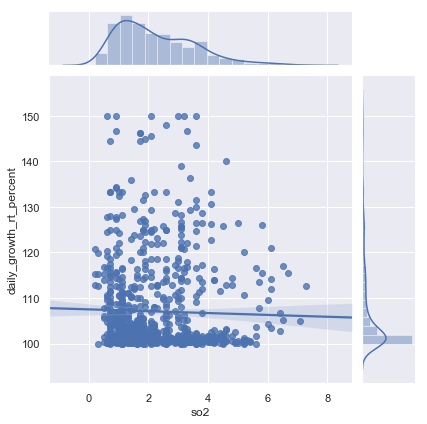

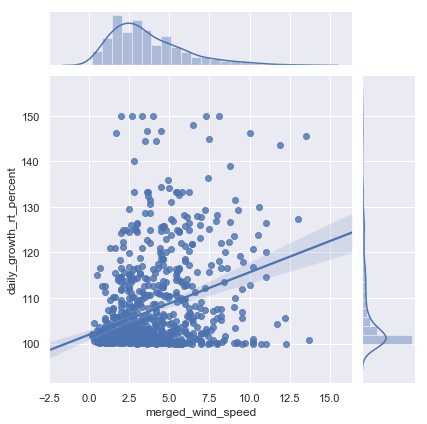

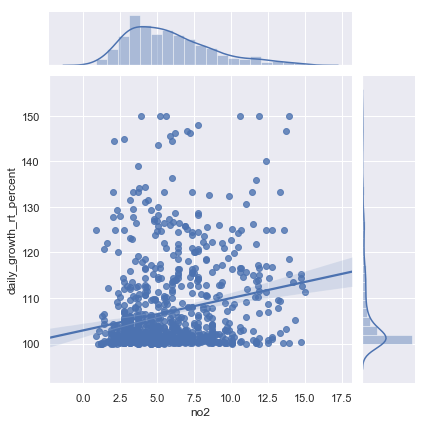

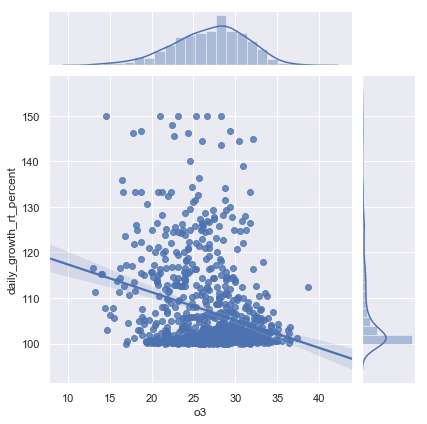

In [234]:
# few counts across cities and hence metric with population
h=4
sns.jointplot(x="so2", y=metric_name, data=df_aq_day1_joined_cd_day7_with_metrics_nona,kind="reg");
sns.jointplot(x="merged_wind_speed", y=metric_name, data=df_aq_day1_joined_cd_day7_with_metrics_nona,kind="reg");
sns.jointplot(x="no2", y=metric_name, data=df_aq_day1_joined_cd_day7_with_metrics_nona,kind="reg");
sns.jointplot(x="o3", y=metric_name, data=df_aq_day1_joined_cd_day7_with_metrics_nona,kind="reg");


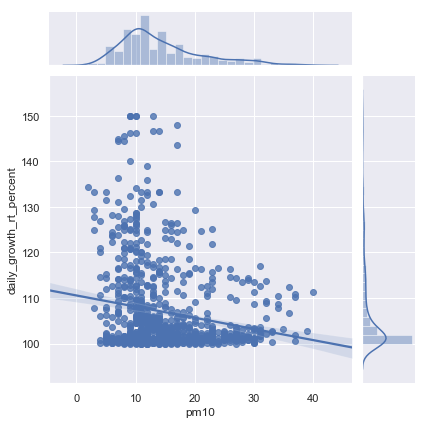

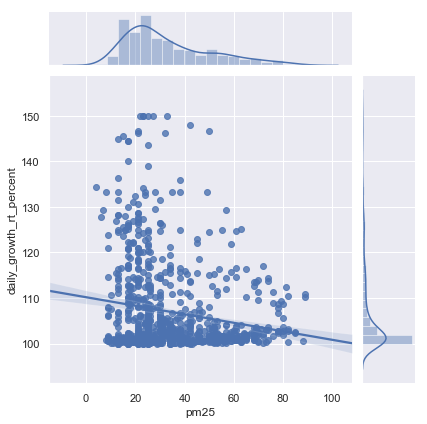

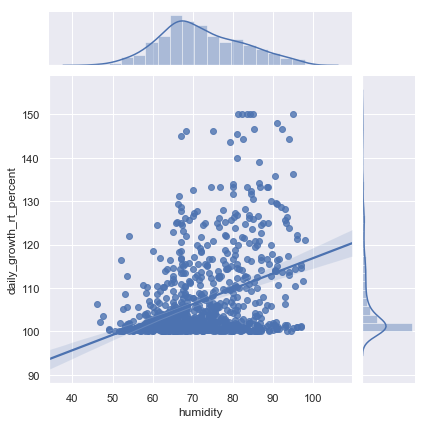

In [236]:
sns.jointplot(x="pm10", y=metric_name, data=df_aq_day1_joined_cd_day7_with_metrics_nona,kind="reg");
sns.jointplot(x="pm25", y=metric_name, data=df_aq_day1_joined_cd_day7_with_metrics_nona,kind="reg");
sns.jointplot(x="humidity", y=metric_name, data=df_aq_day1_joined_cd_day7_with_metrics_nona,kind="reg");

(878, 17)


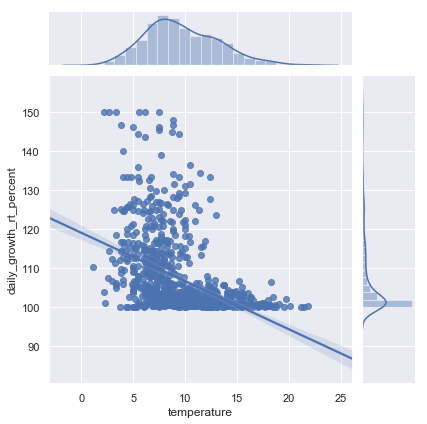

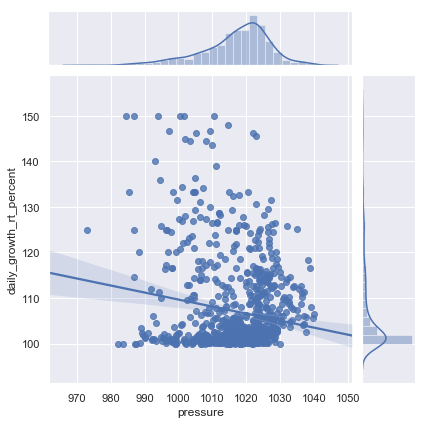

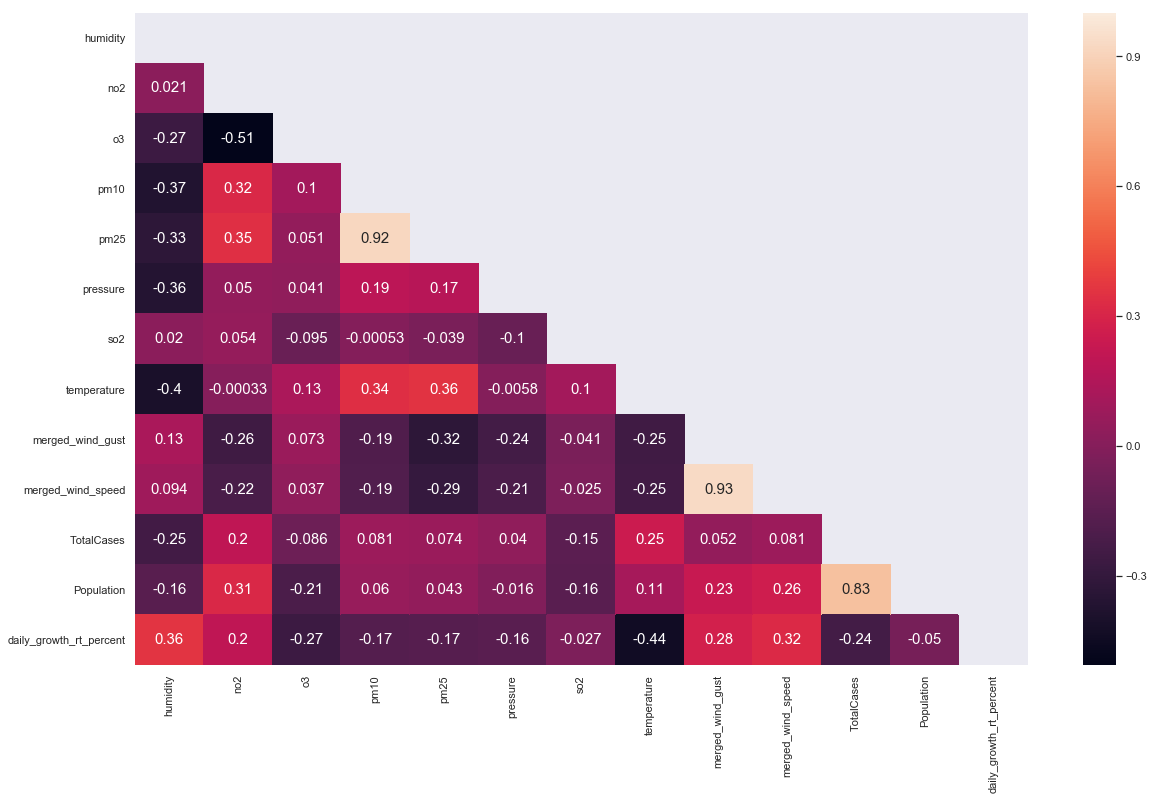

In [295]:
sns.jointplot(x="temperature", y=metric_name, data=df_aq_day1_joined_cd_day7_with_metrics_nona,kind="reg");
sns.jointplot(x="pressure", y=metric_name, data=df_aq_day1_joined_cd_day7_with_metrics_nona,kind="reg");
plt.figure(figsize = (20,12))
#print(df_aq_day1_joined_cd_day7_with_metrics_nona.corr())
matrix = np.triu(df_aq_day1_joined_cd_day7_with_metrics_nona.corr())
sns.heatmap(df_aq_day1_joined_cd_day7_with_metrics_nona.corr(), annot=True, mask=matrix,annot_kws={"size":15})
print(df_aq_day1_joined_cd_day7_with_metrics_nona.shape)

## 5.0 Conclusion

To summerise, both the iterations 1 and 2 support the same observation. The metric 'daily growth rate percentage' of number of cases has a relationship (not very strong though) with the following air quality factors -

1. NO2           - daily growth rate increases with the increase of NO2 in the air ( r=0.2)
2. O3            - daily growth rate decreases with the increase of O3 in the air (r=-0.27)
3. PM25 and PM10 - negetively correlated - although r is on the lower side
4. Humidity      - daily growth rate increases with the increase of humidity in the air (r=0.36)
5. Temperature   - daily growth rate increases with the decrease of O3 in the air (r=-0.44)
6. Wind speed    - daily growth rate increases with the increase of wind speed (r=0.32). May be wind speed helps to spread the virus quickly

The above findings need to be validated with 

1. with more datasets from other cities and regions (specially suburbs) from different counties
2. with more COVID-19 metrics such as number of deaths, severity of infections etc.

As the infection growth rate depends on NO2, humidity, temperature and wind speed, the social distancing measures must be strictly followed even in the cooler days, humid/windy weather conditions and where the conentration of NO2 is high in the air.
	


In [ ]:
#End of the document